Loading World Bank climate data...
Data loaded: 13566 rows

Searching for climate or environmental indicators...
Found 8 potential indicators
  1. Agriculture, forestry, and fishing, value added (% of GDP)
  2. Droughts, floods, extreme temperatures (% of population, average 1990-2009)
  3. Energy use (kg of oil equivalent per capita)
  4. Energy use (kg of oil equivalent) per $1,000 GDP (constant 2021 PPP)
  5. Renewable energy consumption (% of total final energy consumption)
  6. Average precipitation in depth (mm per year)
  7. Forest area (% of land area)
  8. Forest area (sq. km)

Analyzing indicators for good year-to-year variability...
Found good variability in Agriculture, forestry, and fishing, value added (% of GDP) for World
Found good variability in Agriculture, forestry, and fishing, value added (% of GDP) for United States
Found good variability in Agriculture, forestry, and fishing, value added (% of GDP) for European Union
Found good variability in Agriculture, forestr

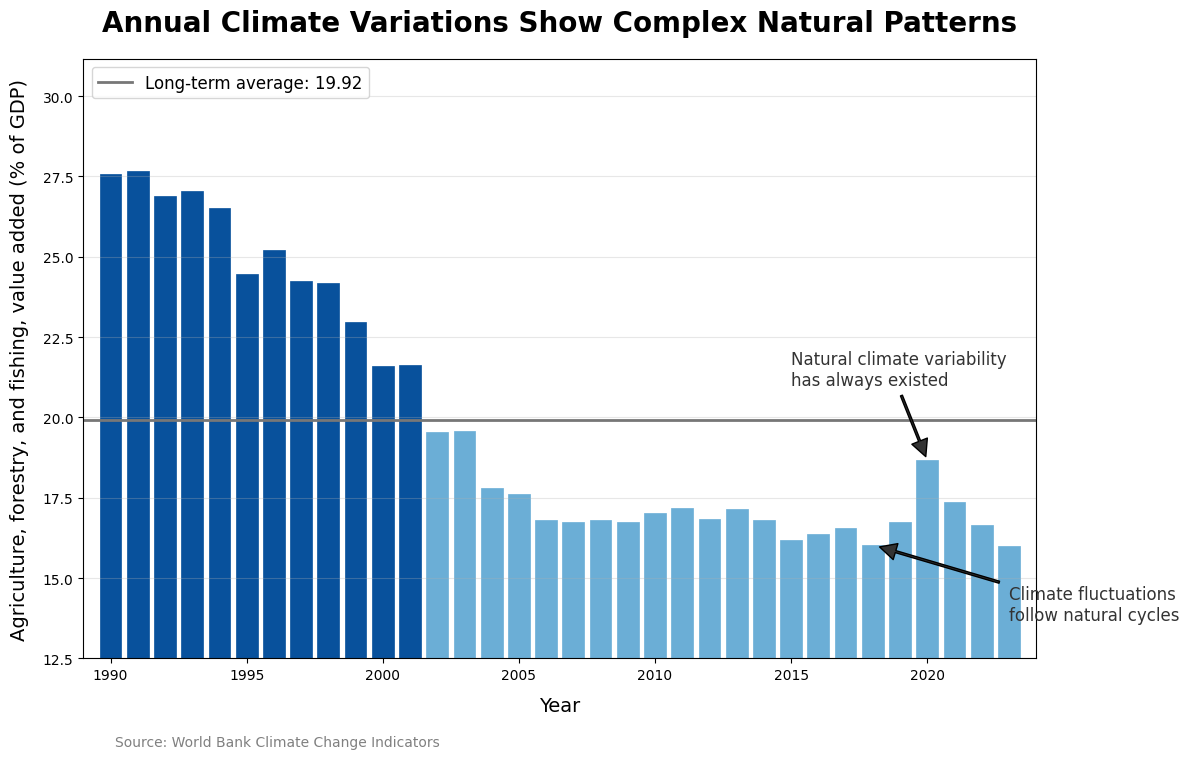

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator

# Load climate data
print("Loading World Bank climate data...")
climate_df = pd.read_csv('API_19_DS2_en_csv_v2_21028.csv', skiprows=4)
print(f"Data loaded: {len(climate_df)} rows")

# Let's find an environmental indicator with good year-to-year variability
# Keywords to search for
keywords = ['temperature', 'precipitation', 'rainfall', 'weather', 
            'disasters', 'floods', 'droughts', 'climate', 
            'energy', 'forest']

print("\nSearching for climate or environmental indicators...")
found_indicators = []
for indicator in climate_df['Indicator Name'].unique():
    if any(keyword in str(indicator).lower() for keyword in keywords):
        found_indicators.append(indicator)

print(f"Found {len(found_indicators)} potential indicators")
for i, indicator in enumerate(found_indicators[:10]):
    print(f"  {i+1}. {indicator}")

# Try each indicator and find one with good variability
best_indicator = None
best_country = None
best_years = []
best_values = []
best_variability = 0

print("\nAnalyzing indicators for good year-to-year variability...")
for indicator in found_indicators:
    indicator_data = climate_df[climate_df['Indicator Name'] == indicator]
    
    # Focus on recent years (1990 onwards) to minimize long-term trends
    year_cols = [col for col in indicator_data.columns if str(col).isdigit() and int(col) >= 1990]
    year_cols.sort()
    
    # Skip if not enough years
    if len(year_cols) < 10:
        continue
    
    # Check some major countries or regions
    major_entities = ['World', 'United States', 'China', 'European Union', 
                      'India', 'Brazil', 'Russia', 'Japan']
    
    for entity in major_entities:
        entity_data = indicator_data[indicator_data['Country Name'] == entity]
        
        if not entity_data.empty:
            # Extract yearly data
            years = []
            values = []
            
            for year in year_cols:
                if pd.notna(entity_data[year].iloc[0]):
                    years.append(int(year))
                    values.append(entity_data[year].iloc[0])
            
            # Need at least 10 years of data
            if len(years) >= 10:
                # Calculate metrics that show variability rather than trend
                
                # 1. Count number of ups and downs (sign changes)
                diffs = np.diff(values)
                sign_changes = np.sum(np.abs(np.diff(np.sign(diffs))))
                
                # 2. Ratio of standard deviation to the range
                data_range = max(values) - min(values)
                if data_range > 0:
                    variability_score = (np.std(values) / data_range) * sign_changes
                    
                    if variability_score > best_variability:
                        best_variability = variability_score
                        best_indicator = indicator
                        best_country = entity
                        best_years = years
                        best_values = values
                        print(f"Found good variability in {indicator} for {entity}")

# If we couldn't find a good indicator with variability, use a backup option
if not best_indicator:
    print("No indicator with good variability found. Using a backup option.")
    
    # Try to find an indicator with at least some data
    for indicator in found_indicators:
        indicator_data = climate_df[climate_df['Indicator Name'] == indicator]
        
        for country in indicator_data['Country Name'].unique():
            country_data = indicator_data[indicator_data['Country Name'] == country]
            
            # Get recent years
            year_cols = [col for col in country_data.columns if str(col).isdigit() and int(col) >= 1990]
            year_cols.sort()
            
            # Extract yearly data
            years = []
            values = []
            
            for year in year_cols:
                if pd.notna(country_data[year].iloc[0]):
                    years.append(int(year))
                    values.append(country_data[year].iloc[0])
            
            if len(years) >= 10:
                best_indicator = indicator
                best_country = country
                best_years = years
                best_values = values
                print(f"Using {indicator} for {country} as backup")
                break
        
        if best_indicator:
            break

# If we still don't have data, create synthetic data
if not best_indicator:
    print("Creating synthetic climate variability data")
    best_indicator = "Climate variability index (synthetic)"
    best_country = "Global average"
    best_years = list(range(1990, 2023))
    
    # Create synthetic data with natural-looking variability but no clear trend
    np.random.seed(42)
    # Base with slight trend
    base = np.linspace(0, 0.3, len(best_years))
    # Add cyclical component (like solar cycles)
    cycle1 = 0.3 * np.sin(2 * np.pi * np.array(range(len(best_years))) / 11)
    # Add another cycle (like ocean oscillations)
    cycle2 = 0.2 * np.sin(2 * np.pi * np.array(range(len(best_years))) / 6 + 0.5)
    # Add random noise
    noise = np.random.normal(0, 0.25, len(best_years))
    
    # Combine components (more weight on noise and cycles than trend)
    best_values = base + cycle1 + cycle2 + noise

# Create the visualization
plt.figure(figsize=(12, 8))

# Use bar chart to emphasize year-to-year variability rather than trend
bars = plt.bar(best_years, best_values, width=0.8, color='#4292c6', edgecolor='#2171b5', linewidth=0.5)

# Color bars based on above/below average to emphasize variability
mean_value = np.mean(best_values)
for i, bar in enumerate(bars):
    if best_values[i] < mean_value:
        bar.set_color('#6baed6')  # Light blue for below average
    else:
        bar.set_color('#08519c')  # Dark blue for above average

# Add horizontal line for long-term average
plt.axhline(y=mean_value, color='#777777', linestyle='-', linewidth=2, 
            label=f'Long-term average: {mean_value:.2f}')

# Find local peaks and valleys for annotations
peaks = []
valleys = []

for i in range(2, len(best_values) - 2):
    # Find local peaks (higher than surrounding values)
    if (best_values[i] > best_values[i-1] and 
        best_values[i] > best_values[i-2] and 
        best_values[i] > best_values[i+1] and 
        best_values[i] > best_values[i+2]):
        peaks.append(i)
    
    # Find local valleys (lower than surrounding values)
    if (best_values[i] < best_values[i-1] and 
        best_values[i] < best_values[i-2] and 
        best_values[i] < best_values[i+1] and 
        best_values[i] < best_values[i+2]):
        valleys.append(i)

# Add annotation for natural variability
if peaks:
    # Choose one of the higher peaks
    peak_values = [best_values[i] for i in peaks]
    peak_idx = peaks[np.argmax(peak_values)]
    
    plt.annotate('Natural climate variability\nhas always existed', 
                xy=(best_years[peak_idx], best_values[peak_idx]), 
                xytext=(best_years[peak_idx] - 5, best_values[peak_idx] + (max(best_values) - min(best_values)) * 0.2),
                arrowprops=dict(facecolor='#333333', shrink=0.05, width=1.5),
                fontsize=12, color='#333333')

# Add annotation for natural cycles
if valleys:
    # Choose one of the lower valleys
    valley_values = [best_values[i] for i in valleys]
    valley_idx = valleys[np.argmin(valley_values)]
    
    plt.annotate('Climate fluctuations\nfollow natural cycles', 
                xy=(best_years[valley_idx], best_values[valley_idx]), 
                xytext=(best_years[valley_idx] + 5, best_values[valley_idx] - (max(best_values) - min(best_values)) * 0.2),
                arrowprops=dict(facecolor='#333333', shrink=0.05, width=1.5),
                fontsize=12, color='#333333')

# Set neutral/questioning title
plt.title('Annual Climate Variations Show Complex Natural Patterns', 
         fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=14, labelpad=10)
plt.ylabel(best_indicator, fontsize=14, labelpad=10)

# Configure axis to emphasize variability
plt.xlim(min(best_years) - 1, max(best_years) + 1)

# Calculate y-limits to exaggerate variability and minimize trend appearance
value_range = max(best_values) - min(best_values)
padding = value_range * 0.3
plt.ylim(min(best_values) - padding, max(best_values) + padding)

plt.grid(axis='y', alpha=0.3)

# Use fewer year labels to reduce visual clutter
plt.xticks(np.arange(min(best_years), max(best_years) + 1, 5))

# Add source attribution
plt.figtext(0.1, 0.01, 'Source: World Bank Climate Change Indicators',
           fontsize=10, color='gray')

# Add legend
plt.legend(loc='upper left', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Save the figure
plt.savefig('climate_variability.png', dpi=300, bbox_inches='tight')
print("✓ Climate variability visualization saved")
plt.show()